In [63]:
# !pip install gurobipy matplotlib numpy -q

# **Approximation Algorithm for Disjoint Regions in TSP with Neighborhoods**


**Import Libraries**



In [64]:
# Import necessary libraries
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import itertools


**Generate Synthetic Data for Regions**

In [65]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of regions and points per region
m = 5
points_per_region = 7
regions = []

# Generate points for each region
for _ in range(m):
    center = np.random.rand(2) * 100  # Random center for each region
    region_points = center + np.random.randn(points_per_region, 2) * 5  # Points spread around center
    regions.append(region_points)

# Flatten all points and store region assignments
all_points = []
region_idx = []

for i, pts in enumerate(regions):
    all_points.extend(pts)
    region_idx.extend([i] * len(pts))

all_points = np.array(all_points)
n = len(all_points)  # Total number of points

# Compute the distance matrix
dist = np.linalg.norm(all_points[:, None] - all_points[None, :], axis=-1)


**Gurobi Model Setup**

In [66]:
# Initialize Gurobi Model
model = gp.Model("Euclidean_Group_TSP")
model.setParam("OutputFlag", 0)

# Decision variables
x = model.addVars(n, n, vtype=GRB.BINARY, name="x")
y = model.addVars(n, vtype=GRB.BINARY, name="y")
u = model.addVars(n, vtype=GRB.CONTINUOUS, lb=0, ub=n - 1, name="u")


**Constraints Setup**

In [67]:
# Constraint: One point per region
for i in range(m):
    indices = [j for j in range(n) if region_idx[j] == i]
    model.addConstr(gp.quicksum(y[j] for j in indices) == 1)

# Constraint: Edge constraints — must be part of the tour if selected
for i in range(n):
    model.addConstr(gp.quicksum(x[i, j] for j in range(n) if j != i) == y[i])
    model.addConstr(gp.quicksum(x[j, i] for j in range(n) if j != i) == y[i])

# MTZ Subtour Elimination Constraints
for i in range(1, n):
    for j in range(1, n):
        if i != j:
            model.addConstr(u[i] - u[j] + (n - 1) * x[i, j] <= n - 2)


**Objective Function**

In [68]:
# Objective: Minimize total distance
model.setObjective(gp.quicksum(dist[i][j] * x[i, j] for i in range(n) for j in range(n)), GRB.MINIMIZE)


**Solve the Model**

In [69]:
# Optimize the model
model.optimize()

# Check if optimization was successful
if model.status == GRB.OPTIMAL:
    selected_points = [i for i in range(n) if y[i].X > 0.5]
    tour_edges = [(i, j) for i in range(n) for j in range(n) if x[i, j].X > 0.5]

    print("\nOptimization successful!")
    print("Selected Points (Indices):", selected_points)
    print("Tour Edges:")
    for i, j in tour_edges:
        print(f"{i} -> {j}")

else:
    print(f"Optimization was not successful. Status: {model.status}")
    if model.status == GRB.INFEASIBLE:
        print("Model is infeasible.")




Optimization successful!
Selected Points (Indices): [0, 13, 17, 27, 32]
Tour Edges:
0 -> 17
13 -> 32
17 -> 27
27 -> 13
32 -> 0


**Plotting Results**

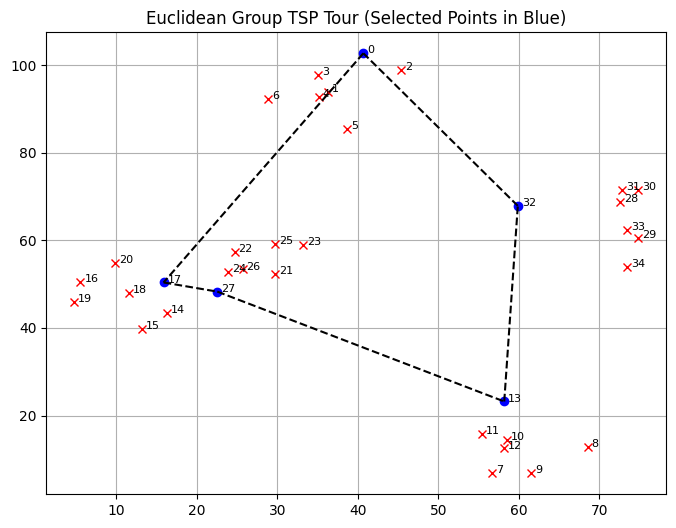

In [70]:
# Plotting the results
plt.figure(figsize=(8, 6))

# Plot points (blue for selected points, red for others)
for i, pt in enumerate(all_points):
    plt.plot(*pt, 'bo' if i in selected_points else 'rx')
    plt.text(pt[0] + 0.5, pt[1], str(i), fontsize=8)

# Plot tour edges
for i, j in tour_edges:
    p1, p2 = all_points[i], all_points[j]
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k--')

plt.title("Euclidean Group TSP Tour (Selected Points in Blue)")
plt.grid(True)
plt.show()


# **Approximation Algorithm for Intersecting Regions in TSP**

**Imports and Parameters**

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.approximation import traveling_salesman_problem, christofides

# Set random seed and parameters
np.random.seed(0)
num_regions = 6
disk_radius = 10
grid_size = 100

**Generate Random Disk Regions**

In [72]:
# Generate random centers for the disk regions
region_centers = np.random.rand(num_regions, 2) * 100

# Each region is a disk: (center_x, center_y, radius)
regions = [(cx, cy, disk_radius) for cx, cy in region_centers]


**Generate Candidate Points**

In [73]:
# Generate a uniform grid of candidate points over the bounding area
grid_x, grid_y = np.meshgrid(np.linspace(0, 100, grid_size), np.linspace(0, 100, grid_size))
candidates = np.vstack([grid_x.ravel(), grid_y.ravel()]).T


**Greedy Geometric Hitting Set**

In [74]:
# Precompute which regions each candidate point hits
region_hits = [[] for _ in candidates]
for idx, pt in enumerate(candidates):
    for ridx, (cx, cy, r) in enumerate(regions):
        if np.linalg.norm(pt - np.array([cx, cy])) <= r:
            region_hits[idx].append(ridx)

# Greedily select points to hit all regions
selected_points = []
covered_regions = set()

while len(covered_regions) < num_regions:
    best_candidate = -1
    best_covered = set()

    for i, hits in enumerate(region_hits):
        uncovered = set(hits) - covered_regions
        if len(uncovered) > len(best_covered):
            best_candidate = i
            best_covered = uncovered

    if best_candidate == -1:
        raise ValueError("No valid hitting set found. Increase grid resolution or check region setup.")

    selected_points.append(candidates[best_candidate])
    covered_regions.update(best_covered)

selected_points = np.array(selected_points)


**Solve TSP Tour on Hitting Set**

In [75]:
# Build complete graph on selected points
G = nx.complete_graph(len(selected_points))
for i in range(len(selected_points)):
    for j in range(i + 1, len(selected_points)):
        dist = np.linalg.norm(selected_points[i] - selected_points[j])
        G[i][j]['weight'] = dist
        G[j][i]['weight'] = dist

# Use Christofides algorithm to compute TSP tour
tsp_order = traveling_salesman_problem(G, weight='weight', cycle=True, method=christofides)

**Visualization**

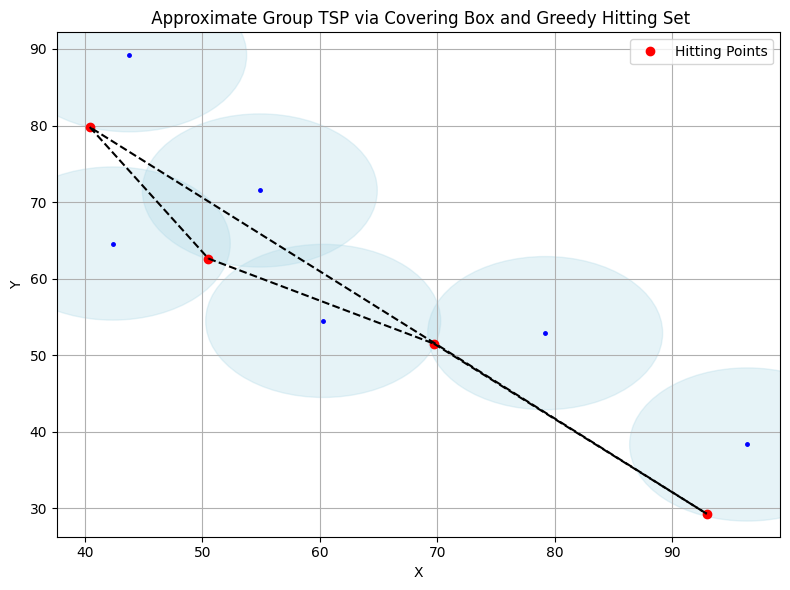

In [76]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot disk regions
for cx, cy, r in regions:
    circle = plt.Circle((cx, cy), r, color='lightblue', alpha=0.3)
    ax.add_artist(circle)
    ax.plot(cx, cy, 'b.', markersize=5)

# Plot selected hitting points
ax.plot(selected_points[:, 0], selected_points[:, 1], 'ro', label="Hitting Points")

# Plot TSP tour
for i in range(len(tsp_order)):
    p1 = selected_points[tsp_order[i]]
    p2 = selected_points[tsp_order[(i + 1) % len(tsp_order)]]
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k--')

ax.set_title(" Approximate Group TSP via Covering Box and Greedy Hitting Set")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()
